In [54]:
#Importing required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() 
import swifter
import dask.dataframe as dd
import multiprocessing
import numpy as np

In [2]:
# Loading data using pandas library and creating an hdf5 file using vaex 

cols = ['Target', 'ID', 'Date', 'Query', 'User', 'Text']
raw_tweets = pd.read_csv('sentiment_140/training.1600000.processed.noemoticon.csv', encoding='latin-1', names = cols)

In [3]:
# the most important thing is the text and the sentiment of it so we will get rid of the rest of the columns

raw_tweets = raw_tweets[['Target', 'Text']]

In [4]:
#Making sure we do not have duplicates

print(raw_tweets.shape)
raw_tweets.drop_duplicates(inplace = True)
print(raw_tweets.shape)

(1600000, 2)
(1583691, 2)


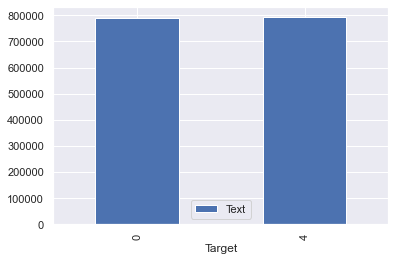

In [5]:
# Looking at the distribution of the tweets
raw_tweets.groupby('Target').count().plot(kind = 'bar')

In [6]:
#importing libraries for cleaning text
import nltk
import re

In [7]:
#Creating a function that deletes extra letters when they are repeated more than 2 times
def reduce_lengthening(text):
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1\1", text)

print(reduce_lengthening( "finallllllly" ))

finally


In [8]:
from pattern.en import suggest

word = "amazzziiing"
word_wlf = reduce_lengthening(word) #calling function defined above
print(word_wlf) #word lengthening isn't being able to fix it completely

correct_word = suggest(word_wlf) 
print(correct_word)

amazziing
[('amazing', 1.0)]


In [9]:
#Creating a function to clean text and git rid of punctuations, stopwords, and lowering the text
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')
from nltk.stem import PorterStemmer
from pattern.en import suggest
ps = PorterStemmer()

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    #reducing charachters that repeat more than twice
    reduced_tokens = [reduce_lengthening(token) for token in tokens]
    #correcting the spelling of words
    corrected = [suggest(token)[0][0] for token in reduced_tokens]
    # filter stopwords and non english words out of document
    filtered_tokens = [token for token in corrected if token not in stop_words]
    # re-create document from filtered tokens
    stem_tokens = [ps.stem(word) for word in filtered_tokens]
    doc = ' '.join(stem_tokens)
    return doc



In [10]:
sample = "I eat 3 upple's with my frend!"
normalize_document(sample)

'eat appl friend'

In [ ]:
# defining a function to clean the text in our dataframe.
def dataframe_normalize(row):
    row.Text = normalize_document(row.Text)
    return(row)

In [ ]:
#Using dask for faster process
norm_tweets = dd.from_pandas(raw_tweets, npartitions=4*multiprocessing.cpu_count())\
    .map_partitions(lambda df: df.apply(dataframe_normalize,axis =1))\
    .compute(scheduler='processes')

In [37]:
norm_tweets = pd.read_csv('clean.csv', encoding='latin-1', header=0)
norm_tweets = norm_tweets[['Target','Text']]
norm_tweets.Target.replace(4,1, inplace =True)
norm_tweets = norm_tweets[norm_tweets.Text.notnull()]

In [15]:
norm_tweets.head()

,Target,Text
0,0,switchfoot httptwitpiccomyzl www summer got da...
1,0,upset updat facebook test might cri result sch...
2,0,kenichan dive mani time ball manag save rest g...
3,0,whole bodi feel itchi like fire
4,0,nationwideclass behav mad see


In [98]:
maxlen = max(norm_tweets['Text'].str.split().apply(len))
print(maxlen)
max_words = 20000
embedding_dim = 100

42


In [57]:
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import layers
from keras.models import Sequential

In [99]:
tokenizer = Tokenizer(num_words = max_words )
tokenizer.fit_on_texts(norm_tweets.Text.values)
sequences = tokenizer.texts_to_sequences(norm_tweets.Text.values)
data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(norm_tweets.Target.values)

x_train, x_test, y_train, y_test = train_test_split(data, labels, random_state=42, test_size=0.3)


In [73]:
model =Sequential()
model.add(layers.Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(layers.LSTM(32))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [74]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy',metrics=['acc'])

history = model.fit(x_train, y_train, epochs = 10, validation_split = 0.2)

c:\users\a_raf\anaconda3\envs\keras-gpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 886324 samples, validate on 221582 samples
Epoch 1/10
886324/886324 [==============================] - 909s 1ms/step - loss: 0.5033 - acc: 0.7560 - val_loss: 0.4871 - val_acc: 0.7646
Epoch 2/10
886324/886324 [==============================] - 876s 988us/step - loss: 0.4855 - acc: 0.7691 - val_loss: 0.4845 - val_acc: 0.7667
Epoch 3/10
886324/886324 [==============================] - 874s 986us/step - loss: 0.4792 - acc: 0.7734 - val_loss: 0.4802 - val_acc: 0.7693
Epoch 4/10
886324/886324 [==============================] - 876s 988us/step - loss: 0.4756 - acc: 0.7760 - val_loss: 0.4793 - val_acc: 0.7707
Epoch 5/10
886324/886324 [==============================] - 874s 986us/step - loss: 0.4726 - acc: 0.7786 - val_loss: 0.4796 - val_acc: 0.7697
Epoch 6/10
886324/886324 [==============================] - 931s 1ms/step - loss: 0.4707 - acc: 0.7799 - val_loss: 0.4807 - val_acc: 0.7691
Epoch 7/10
886324/886324 [==============================] - 928s 1ms/step - loss: 0.4691 - acc: 0.78

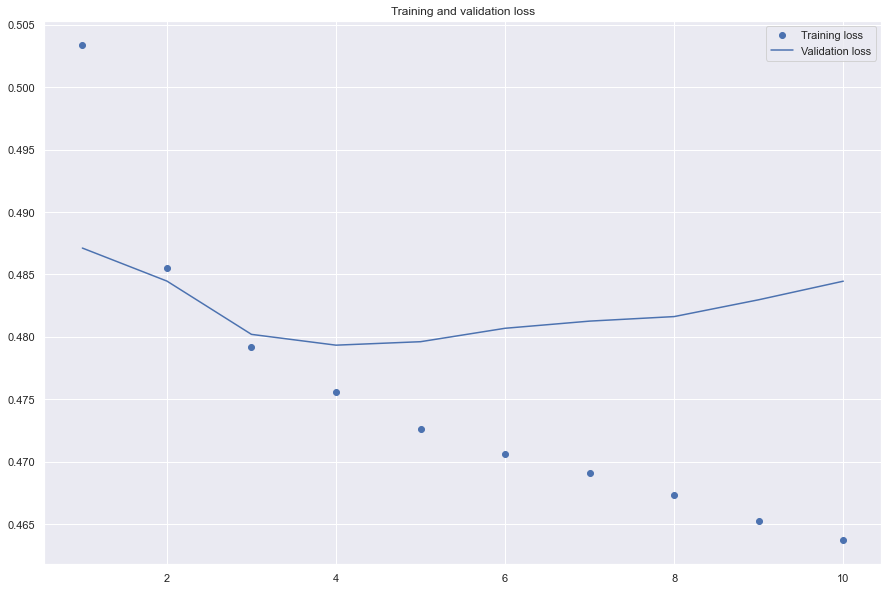

In [76]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(15,10))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

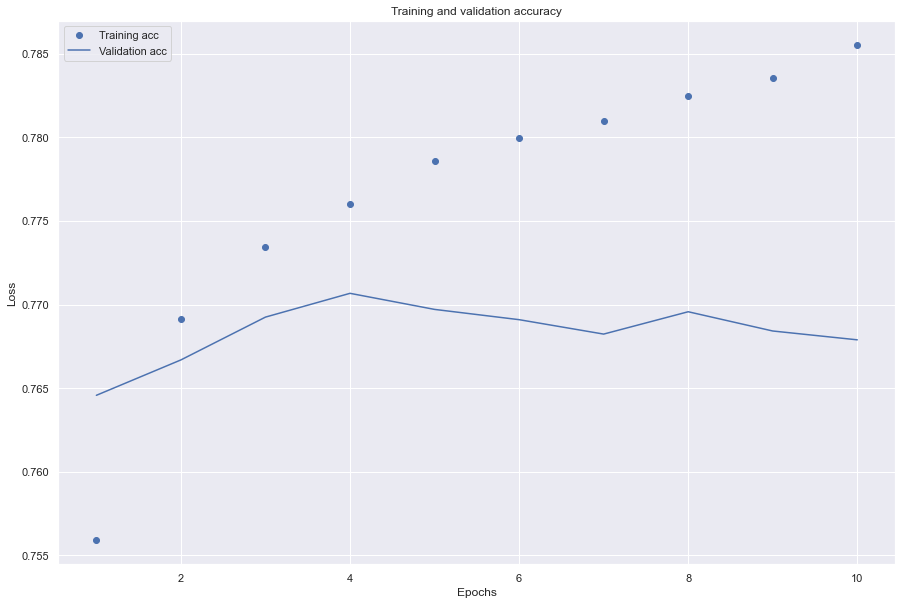

In [77]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.figure(figsize=(15,10))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [90]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

y_test_pred = model.predict(x_test)

print(confusion_matrix(y_test, np.round(y_test_pred)))
print(classification_report(y_test, np.round(y_test_pred)))

[[179559  56801]
 [ 53735 184723]]
              precision    recall  f1-score   support

           0       0.77      0.76      0.76    236360
           1       0.76      0.77      0.77    238458

    accuracy                           0.77    474818
   macro avg       0.77      0.77      0.77    474818
weighted avg       0.77      0.77      0.77    474818



In [97]:
#Training with GlOVE Embeddings
import os

glove_dir = 'glove.6B.100d.txt'
embeddings_index = {}
f = open(glove_dir, encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [101]:
#Assigning Glove vectors to words in ourt tweets

word_index = tokenizer.word_index

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [104]:
model =Sequential()
model.add(layers.Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(layers.LSTM(32))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 42, 100)           2000000   
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 2,017,057
Trainable params: 2,017,057
Non-trainable params: 0
_________________________________________________________________


In [106]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [107]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy',metrics=['acc'])

history = model.fit(x_train, y_train, epochs = 10, validation_split = 0.2)

Train on 886324 samples, validate on 221582 samples
Epoch 1/10
886324/886324 [==============================] - 758s 855us/step - loss: 0.5525 - acc: 0.7156 - val_loss: 0.5274 - val_acc: 0.7345
Epoch 2/10
886324/886324 [==============================] - 762s 860us/step - loss: 0.5330 - acc: 0.7324 - val_loss: 0.5212 - val_acc: 0.7394
Epoch 3/10
886324/886324 [==============================] - 726s 819us/step - loss: 0.5290 - acc: 0.7361 - val_loss: 0.5203 - val_acc: 0.7396
Epoch 4/10
886324/886324 [==============================] - 725s 818us/step - loss: 0.5275 - acc: 0.7377 - val_loss: 0.5224 - val_acc: 0.7381
Epoch 5/10
886324/886324 [==============================] - 699s 789us/step - loss: 0.5272 - acc: 0.7386 - val_loss: 0.5204 - val_acc: 0.7403
Epoch 6/10
886324/886324 [==============================] - 724s 816us/step - loss: 0.5280 - acc: 0.7387 - val_loss: 0.5212 - val_acc: 0.7396
Epoch 7/10
886324/886324 [==============================] - 698s 787us/step - loss: 0.5304 - acc

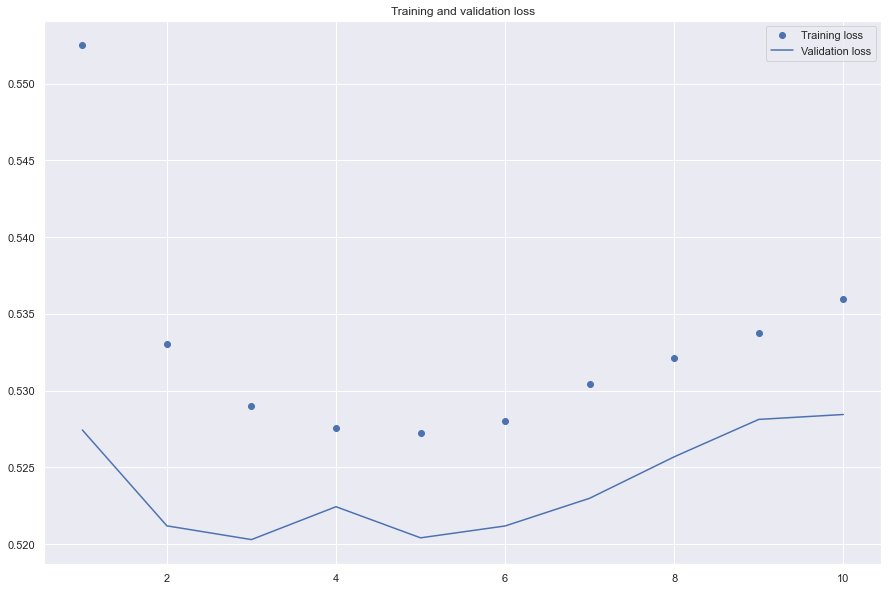

In [108]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(15,10))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

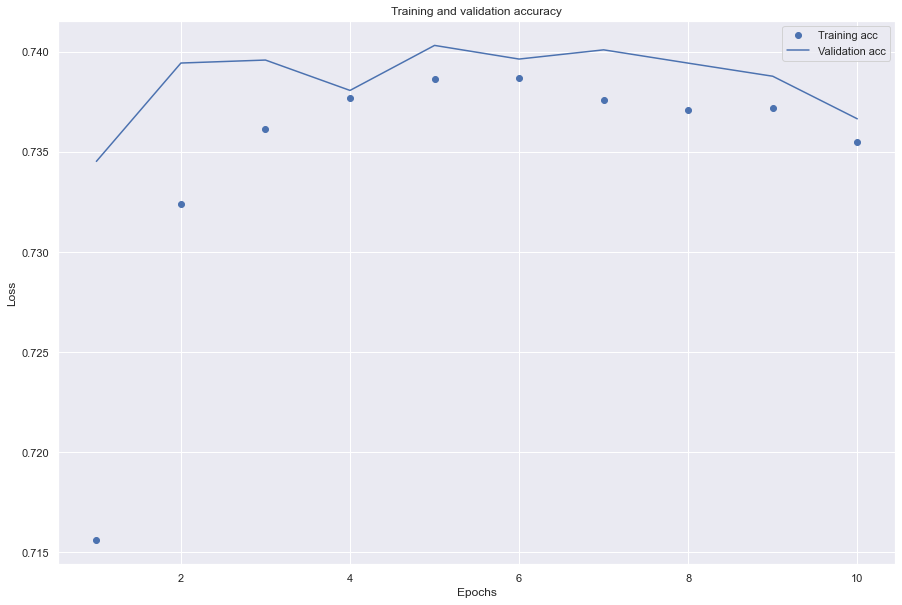

In [109]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.figure(figsize=(15,10))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [110]:
y_test_pred = model.predict(x_test)

print(confusion_matrix(y_test, np.round(y_test_pred)))
print(classification_report(y_test, np.round(y_test_pred)))

[[161705  74655]
 [ 50718 187740]]
              precision    recall  f1-score   support

           0       0.76      0.68      0.72    236360
           1       0.72      0.79      0.75    238458

    accuracy                           0.74    474818
   macro avg       0.74      0.74      0.74    474818
weighted avg       0.74      0.74      0.74    474818

